# Projet 6: Détéction de faux billets

Nous allons preparer les données.

In [1]:
# Import des librairies
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st
import seaborn as sns
import sklearn as sk
import pandas as pd
import numpy as np
import re

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from matplotlib.collections import LineCollection
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn import decomposition, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import statsmodels.formula.api as smf
import statsmodels.api as sm

import functions as f


In [2]:
df = pd.read_csv("Data/setBillets.csv")
df.head(10)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55
5,True,172.57,104.65,104.44,4.54,2.99,113.16
6,True,172.38,103.55,103.80,3.97,2.90,113.30
7,True,171.58,103.65,103.37,3.54,3.19,113.38
8,True,171.96,103.51,103.75,4.06,3.33,113.53
9,True,172.14,104.34,104.20,4.63,3.02,112.47


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    bool   
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.3 KB


On regarde s'il y a des individus négatifs ou nul.

In [4]:

df.diagonal = [ np.nan if i <= 0 else i for i in df.diagonal ]
df.height_left = [ np.nan if i <= 0 else i for i in df.height_left ]
df.height_right = [ np.nan if i <= 0 else i for i in df.height_right ]
df.margin_low = [ np.nan if i <= 0 else i for i in df.margin_low ]
df.margin_up = [ np.nan if i <= 0 else i for i in df.margin_up ]
df.length = [ np.nan if i <= 0 else i for i in df.length ]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    bool   
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.3 KB


In [5]:
df.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [6]:
df.max()

is_genuine        1.00
diagonal        173.01
height_left     104.86
height_right    104.95
margin_low        6.28
margin_up         3.68
length          113.98
dtype: float64

In [7]:
df.min()

is_genuine        0.00
diagonal        171.04
height_left     103.23
height_right    103.14
margin_low        3.54
margin_up         2.27
length          109.97
dtype: float64

In [8]:
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


Les étapes précédente nous montre qu'il ne semble pas y avoir de valeur manquante ( elle aurait été repéré par une objet null, ou nan dans les premiers test).

Il ne semble de plus pas y avoir de valeur abhérante ( nous aurions pu avoir un max totalement invraissemblable)



Le nettoyage fini nous allons selectionner selectionner les données pour la suite.

In [9]:
df_chiffre = pd.DataFrame(df.drop('is_genuine',axis=1))
df_chiffreWithGenuine = pd.DataFrame(df)
df_chiffreWithGenuine.is_genuine = [1 if i == True else 0 for i in df_chiffreWithGenuine.is_genuine]

In [10]:
df_chiffre.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.67,103.74,103.70,4.01,2.87,113.29
2,171.83,103.76,103.76,4.40,2.88,113.84
3,171.80,103.78,103.65,3.73,3.12,113.63
4,172.05,103.70,103.75,5.04,2.27,113.55


## Mission 0 : Analyse Uni/Bivariée

Nous utiliseront le dataframe que nous avons construit plus haut.

### Univariée

In [11]:
diag = df_chiffre.diagonal
heiL = df_chiffre.height_left 
heiR = df_chiffre.height_right
marL = df_chiffre.margin_low
marU = df_chiffre.margin_up
leng = df_chiffre.length

In [12]:
diag_mean = diag.mean()
diag_medi = diag.median()
diag_mode = diag.mode()
diag_var = diag.var()
diag_std = diag.std()

heiL_mean = heiL.mean()
heiL_medi = heiL.median()
heiL_mode = heiL.mode()
heiL_var = heiL.var()
heiL_std = heiL.std()

heiR_mean = heiR.mean()
heiR_medi = heiR.median()
heiR_mode = heiR.mode()
heiR_var = heiR.var()
heiR_std = heiR.std()

marL_mean = marL.mean()
marL_medi = marL.median()
marL_mode = marL.mode()
marL_var = marL.var()
marL_std = marL.std()

marU_mean = marU.mean()
marU_medi = marU.median()
marU_mode = marU.mode()
marU_var = marU.var()
marU_std = marU.std()

leng_mean = leng.mean()
leng_medi = leng.median()
leng_mode = leng.mode()
leng_var = leng.var()
leng_std = leng.std()

In [13]:
print("Diagonale moyenne :{} \n un ecart-type :{}, \n median :{} \n mode :{} ,\n variance :{}"
      .format("%.2f" % diag_mean, 
              "%.2f" % diag_std,
              diag_medi,
              diag_mode[0],
              "%.4f" % diag_var))


Diagonale moyenne :171.94 
 un ecart-type :0.31, 
 median :171.945 
 mode :172.1 ,
 variance :0.0935


In [14]:
print("Height left moyenne :{} \n un ecart-type :{}, \n median :{} \n mode :{} ,\n variance :{}"
      .format("%.2f" % heiL_mean, 
              "%.2f" % heiL_std,
              heiL_medi,
              heiL_mode[0],
             "%.4f" % heiL_var))


Height left moyenne :104.07 
 un ecart-type :0.30, 
 median :104.055 
 mode :104.17 ,
 variance :0.0889


In [15]:
print("Height right moyenne :{} \n un ecart-type :{}, \n median :{} \n mode :{} ,\n variance :{}"
      .format("%.2f" % heiR_mean, 
              "%.2f" % heiR_std,
              heiR_medi,
              heiR_mode[0],
             "%.4f" % heiR_var))


Height right moyenne :103.93 
 un ecart-type :0.33, 
 median :103.95 
 mode :103.76 ,
 variance :0.1095


In [16]:
print("Margin low moyenne :{} \n un ecart-type :{}, \n median :{} \n mode :{} ,\n variance :{}"
      .format("%.2f" % marL_mean, 
              "%.2f" % marL_std,
              marL_medi,
              marL_mode[0],
             "%.4f" % marL_var))


Margin low moyenne :4.61 
 un ecart-type :0.70, 
 median :4.45 
 mode :3.97 ,
 variance :0.4929


In [17]:
print("Margin Up moyenne :{} \n un ecart-type :{}, \n median :{} \n mode :{} ,\n variance :{}"
      .format("%.2f" % marU_mean, 
              "%.2f" % marU_std,
              marU_medi,
              marU_mode[0],
             "%.4f" % marU_var))


Margin Up moyenne :3.17 
 un ecart-type :0.24, 
 median :3.17 
 mode :3.07 ,
 variance :0.0559


In [18]:
print("length moyenne :{} \n un ecart-type :{}, \n median :{} \n mode :{} ,\n variance :{}"
      .format("%.2f" % leng_mean, 
              "%.2f" % leng_std,
              leng_medi,
              leng_mode[0],
             "%.4f" % leng_var))


length moyenne :112.57 
 un ecart-type :0.92, 
 median :112.845 
 mode :113.38 ,
 variance :0.8546


In [19]:
df.is_genuine.value_counts()

True     100
False     70
Name: is_genuine, dtype: int64

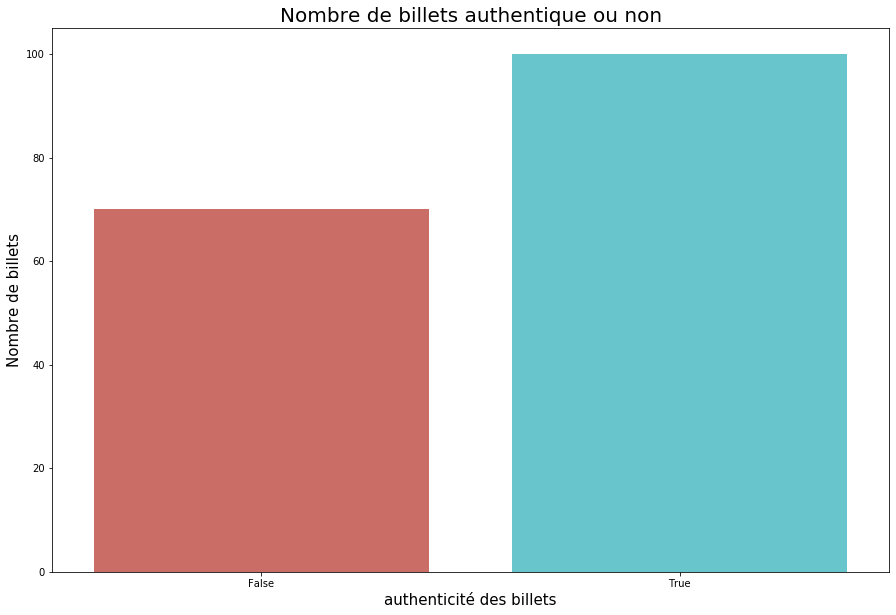

In [20]:
plt.figure(figsize=(15,10))
sns.countplot(x='is_genuine', data=df, palette='hls')
plt.xlabel('authenticité des billets',fontsize=15)
plt.ylabel("Nombre de billets",fontsize=15)
plt.title("Nombre de billets authentique ou non",fontsize=20)
plt.show()

In [21]:
count_false = len(df[df['is_genuine']==False])
count_True = len(df[df['is_genuine']==True])
pct_of_False = count_false/(count_false+count_True)
print("pourcentage de billets faux :", pct_of_False*100)
pct_of_True = count_True/(count_false+count_True)
print("pourcentage de billets vrai :", pct_of_True*100)

pourcentage de billets faux : 41.17647058823529
pourcentage de billets vrai : 58.82352941176471


### Bivariée

Nous allons regarder ici les differentes corrélations qu'il pourrait y avoire entre les variables

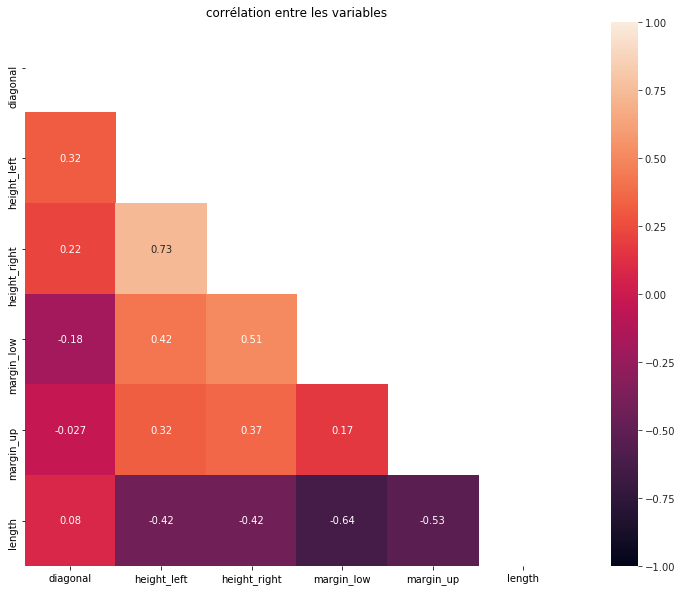

In [22]:
plt.figure(figsize=(15,10))
plt.title("corrélation entre les variables")

corr = df_chiffre.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmin = -1,vmax=1, square=True,annot=True)

plt.show()

On peut noté une corrélation importante entre _height\_right_ et _height\_left_

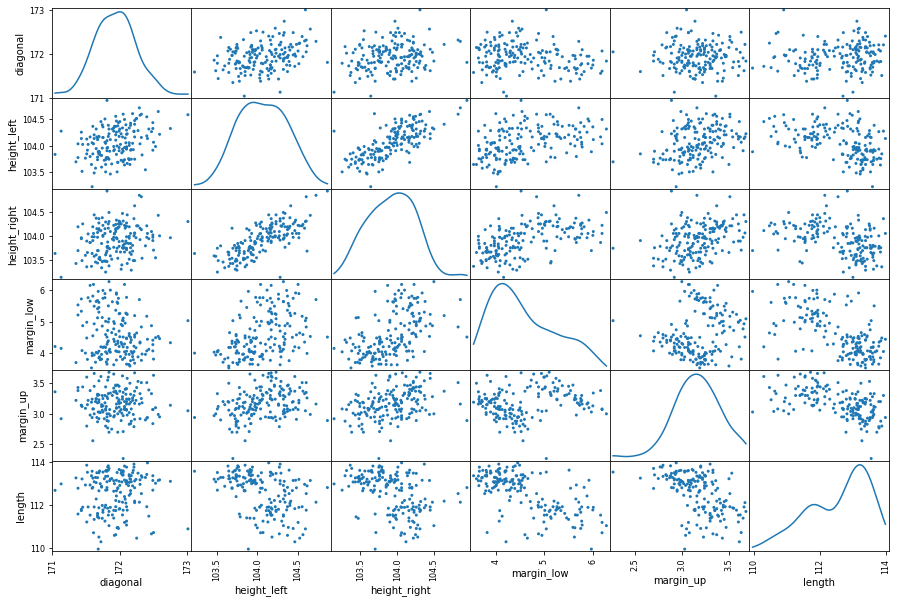

In [23]:
pd.plotting.scatter_matrix(df_chiffre, alpha=1, figsize=(15,10), diagonal='kde')
plt.show()

La projection des individus souligne la meme observation, on voit clairement le lien qu'il peut y avoir entre les deux variable.

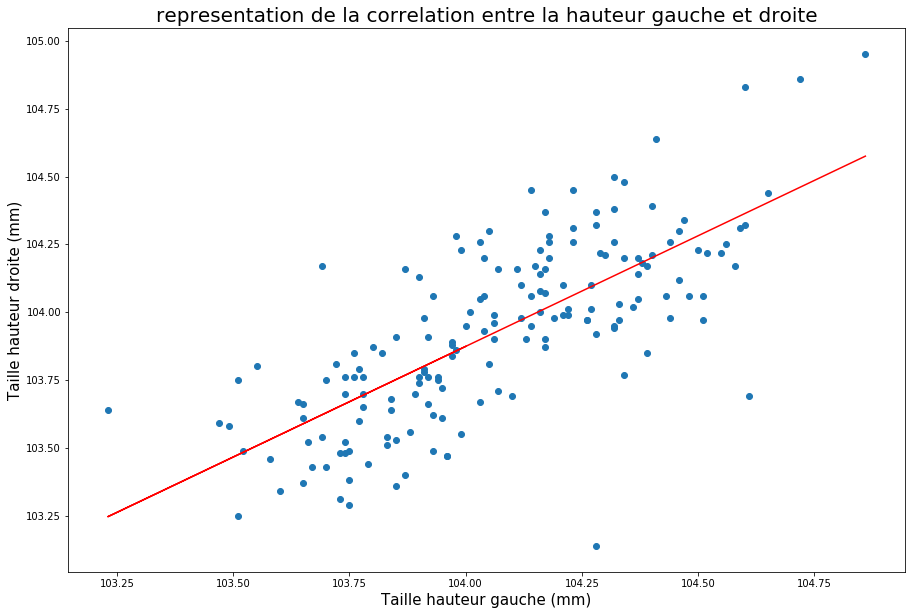

In [24]:

X = df_chiffre.height_left
Y = df_chiffre.height_right


slope, intercept, r_value, p_value, std_err = st.linregress(X, Y)

def predict(x):
   return slope * x + intercept

fitLine = predict(X)

plt.figure(figsize=(15,10))
axes = plt.axes()
axes.grid() 
plt.scatter(X,Y)
plt.plot(X, fitLine, c='r')
plt.xlabel('Taille hauteur gauche (mm)',fontsize=15)
plt.ylabel("Taille hauteur droite (mm)",fontsize=15)
plt.title("representation de la correlation entre la hauteur gauche et droite",fontsize=20)
plt.grid(False)
plt.show()


# Mission 1 : ACP

### Eboulis des valeur propres

Nous allons dans un premier temp faire un eboulis des valeur propre, pour voire combien d'axes etudier.

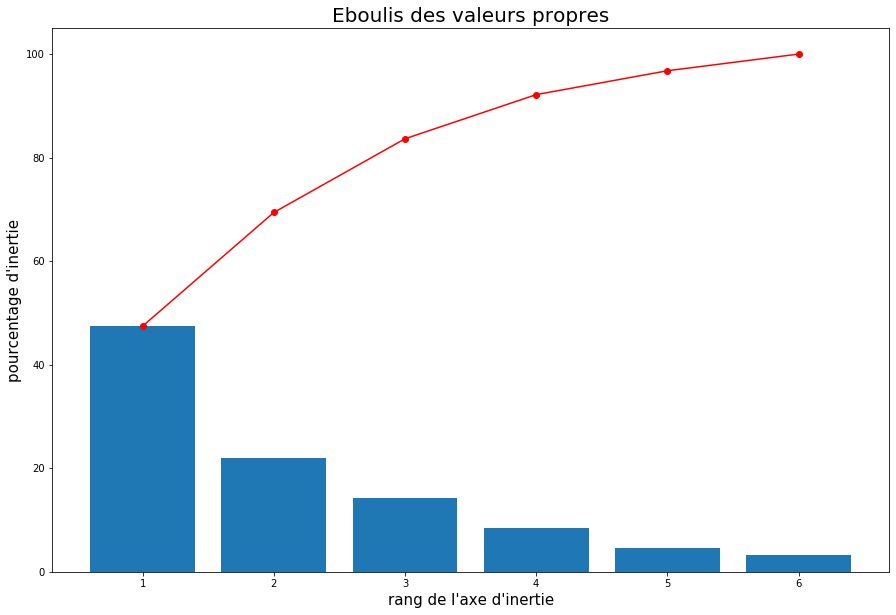

In [25]:
# selection des colonnes à prendre en compte dans l'ACP
data_acp = df_chiffre

#Nombre de composante a calculer
n_comp = 6


# Récuperation des données pour l'ACP
X = data_acp.values

# Réduction Centrage
std_scale = sk.preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
# X_scaled = X


# Calcul des composantes principales
pca = sk.decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)


#Eboulis des valeurs propres
plt.figure(figsize=(15,10))

scree = pca.explained_variance_ratio_*100

plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')

plt.xlabel("rang de l'axe d'inertie", fontsize=15)
plt.ylabel("pourcentage d'inertie", fontsize=15)
plt.title("Eboulis des valeurs propres",fontsize=20)
plt.show()

On peut voire sur l'éboulis que le premier plan represente plus de 60% de l'inertie. De plus en considerant le critere de **Kaiser** on peut négliger les axes qui represente moins de _(100/p)%_ d'inertie avec ici p a 6 soit 16.66%

In [26]:
scree = pd.DataFrame(scree.round(3), index=('Axe 1','Axe 2','Axe 3','Axe 4','Axe 5','Axe 6'))
scree.columns = ['Inertie %']
scree

,Inertie %
Axe 1,47.448
Axe 2,21.957
Axe 3,14.235
Axe 4,8.526
Axe 5,4.613
Axe 6,3.221


Ici on gardera l'axe 2 pour pouvoir faire un plan

### Cercle de corrélation

Projetons le cercle de corrélation des variables

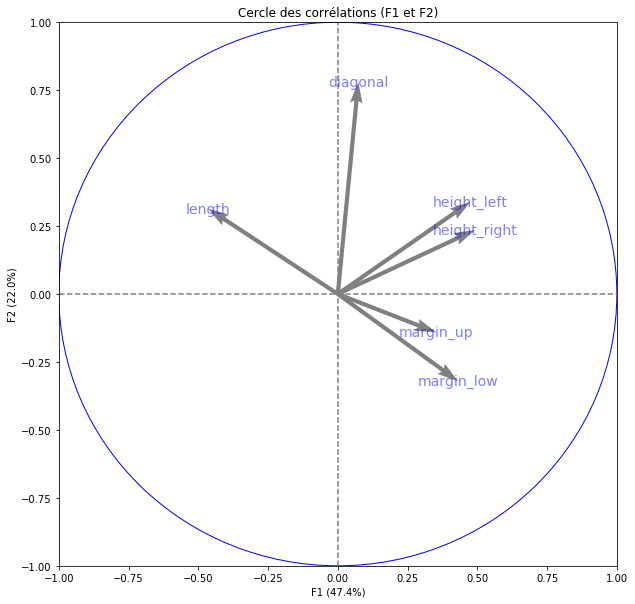

In [27]:
#les intitulés
names = data_acp.index 
features = data_acp.columns

pca = sk.decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)
pcs = pca.components_

f.display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))


In [28]:
df_contribution = pd.DataFrame(pcs,index=['f1','f2','f3','f4', 'f5', 'f6'],
                      columns=["diagonal","heigh right","heigh left","margin low","margin up","lengh"])
df_contribution.round(3)

,diagonal,heigh right,heigh left,margin low,margin up,lengh
f1,0.073,0.476,0.492,0.431,0.353,-0.465
f2,0.780,0.339,0.236,-0.321,-0.141,0.315
f3,-0.089,0.123,0.154,0.513,-0.821,0.127
f4,-0.560,0.278,0.459,-0.227,0.135,0.574
f5,-0.225,0.716,-0.487,-0.312,-0.194,-0.254
f6,0.122,0.232,-0.481,0.548,0.354,0.524


### Projection des individus

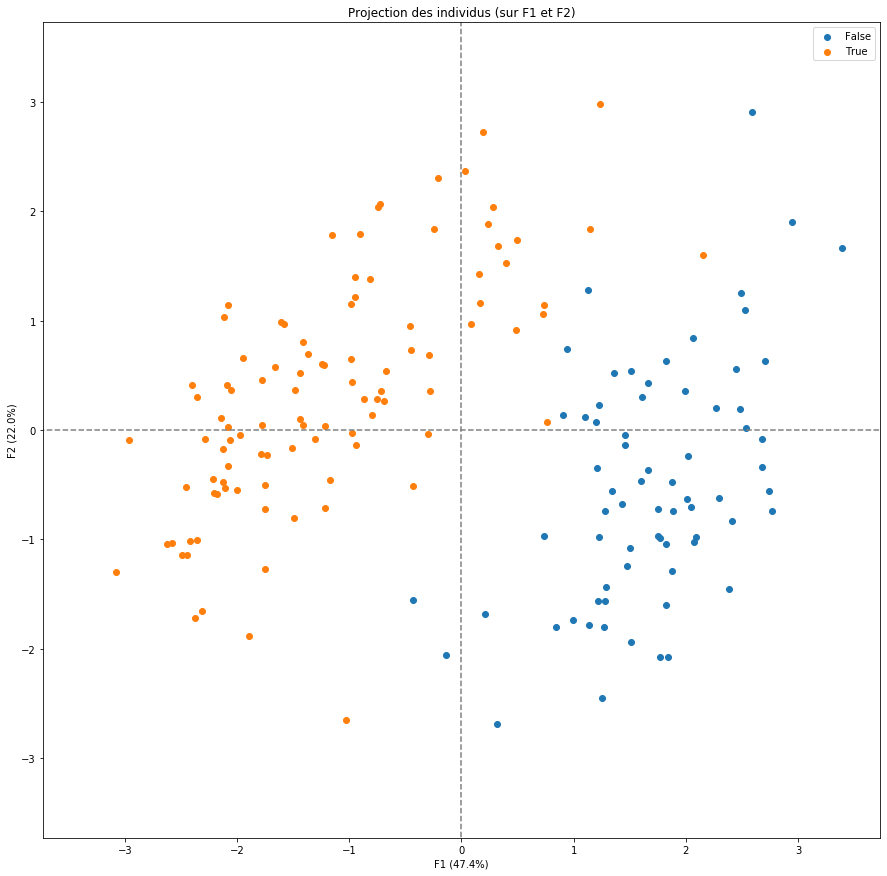

In [29]:
# Projection des individus

X_projected = pca.transform(X_scaled)

f.display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=df['is_genuine'])


Nous avons ici ajouter de la couleur suivant si le billets est ou non vrai. Comme on peut le voire sur cette projection, les billets vrai on un tendance a etre grouper.

## Mission 2: Classification, K-means

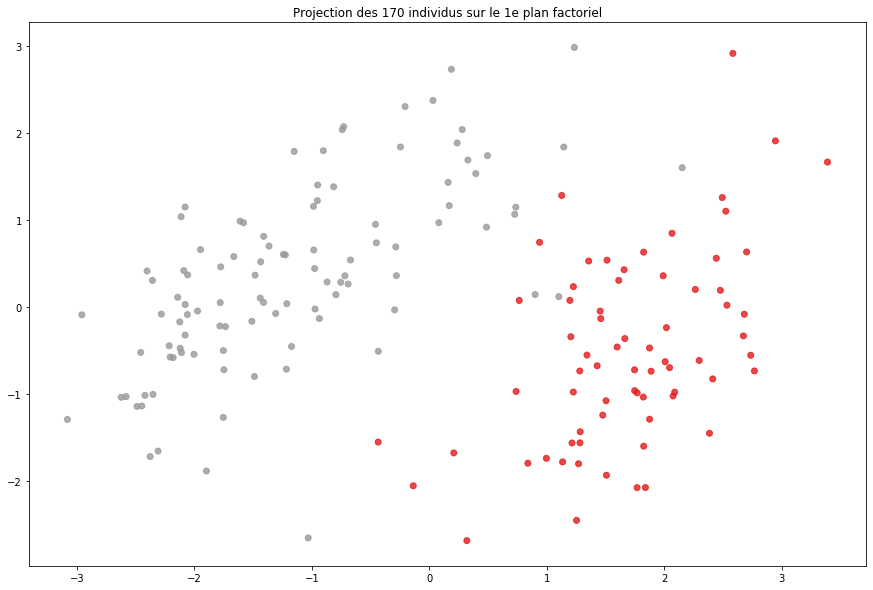

In [30]:
#Nombre de clusters souhaité
n_clust = 2

km = KMeans(n_clusters=n_clust, random_state=3)
km.fit(X)
clusters = km.labels_

df_clusters = pd.DataFrame(clusters)
df_chiffreWithGenuine['cluster'] = df_clusters

plt.figure(figsize=(15,10))

plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float),cmap='Set1', alpha=.8)

plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show()


In [31]:
y_true = df_chiffreWithGenuine.is_genuine
y_pred = df_chiffreWithGenuine.cluster

confMatrix = sk.metrics.confusion_matrix(y_true, y_pred)

df_confMatrix = pd.DataFrame(confMatrix)
df_confMatrix.columns = ['Vrai Billets', 'Faux Billets']
df_confMatrix.index = ['Vrai Billets (prediction)', 'Faux Billets (prediction)']

In [32]:
df_confMatrix

,Vrai Billets,Faux Billets
Vrai Billets (prediction),68,2
Faux Billets (prediction),1,99


On a quelque Vrai negatif, et quelque faux négatif

## Mission 3: Regression logistique

In [33]:
reg_log2 = smf.glm('is_genuine~diagonal+height_left+height_right+margin_low+margin_up+length',
                   data=df_chiffreWithGenuine).fit()
print(reg_log2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                  170
Model:                            GLM   Df Residuals:                      163
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                        0.029188
Method:                          IRLS   Log-Likelihood:                 62.745
Date:                Mon, 04 May 2020   Deviance:                       4.7576
Time:                        15:51:52   Pearson chi2:                     4.76
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -14.0754      8.459     -1.664   

In [34]:

cols = ['diagonal','height_left','height_right','margin_low','margin_up','length']

df_test = pd.read_csv("Data/setTest.csv")

X = df_chiffreWithGenuine[cols]
y = df_chiffreWithGenuine.is_genuine


X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.3,random_state=3)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:

y_pred = logreg.predict(X_test)
print('Précision du classifieur de régression logistique sur le groupe de test: {:.3f} %'
      .format(logreg.score(X_test, y_test)*100))

confusion_matrix = sk.metrics.confusion_matrix(y_test, y_pred)


# print(classification_report(y_test, y_pred))

print(confusion_matrix)

Précision du classifieur de régression logistique sur le groupe de test: 98.039 %
[[15  1]
 [ 0 35]]


## Partie de test de l'echantillons d'évaluations

In [36]:
#Fichier cvs test a changer ici

fichier_test = "Data/setTest.csv"

df_test = pd.read_csv(fichier_test)
x_test_passage = df_test[cols]

y_pred_test = logreg.predict(x_test_passage)
# print('Précision du classifieur de régression logistique sur le groupe de test: {:.3f} %'
#       .format(logreg.score(x_test_passage, y_pred_test)*100))

df_prediction_t = df_test.copy()
df_prediction_t.index = df_prediction_t.id
df_prediction_t = df_prediction_t.drop(columns='id')
df_prediction_t['is_genuine_pred'] = y_pred_test
df_prediction_t.is_genuine_pred = ['True' if i == 1 else 'False' for i in df_prediction_t.is_genuine_pred]
df_prediction_t = df_prediction_t.reindex(columns = ['is_genuine_pred','diagonal','height_left','height_right','margin_low','margin_up','length'])
df_prediction_t


,is_genuine_pred,diagonal,height_left,height_right,margin_low,margin_up,length
id,,,,,,,
A_1,False,171.76,104.01,103.54,5.21,3.30,111.42
A_2,False,171.87,104.17,104.13,6.00,3.31,112.09
A_3,False,172.00,104.58,104.29,4.99,3.39,111.57
A_4,True,172.49,104.55,104.34,4.44,3.03,113.20
A_5,True,171.65,103.63,103.56,3.77,3.16,113.33
